In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/d2nn

/content/drive/My Drive/d2nn


In [ ]:
import tensorflow as tf
import numpy as np
from math import pi
from tensorflow.keras import layers
from scipy.fftpack import fft2
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import pprint
from tempfile import TemporaryFile
import keras
import tensorflow_probability as tfp
from skimage.transform import downscale_local_mean

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Wed Aug  5 04:35:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class normalize_1_complex_image(layers.Layer):

    def __init__(self):
        super(normalize_1_complex_image, self).__init__()

    def call(self, x):
        norm_x = tf.map_fn(self.apply_conv, x)
        return norm_x

    def apply_conv(self, x):
        x_max = tf.reduce_max(input_tensor=tf.abs(x))
        norm_x = tf.math.divide(x, tf.cast(x_max, 'float32'))
        return norm_x

class scale_1_complex_image(layers.Layer):
    ''' Resizes images to original shape x scale
            Original shape x scale must be integer number
            Tensorflow does not support resizing complex valued tensors
            tf.image.resize 
    '''
    def __init__(self, scale):
        super(scale_1_complex_image, self).__init__()
        self.scale = scale

    def call(self, x):
        sx = tf.map_fn(self.apply_scale, x)
        return sx

    def apply_scale(self, x):
        ''' Takes 2-D Tensor, returns scaled 2-D Tensor '''
        s = tf.identity(x)
        s_shape = tf.shape(input=s)
        s = tf.reshape(s, [s_shape[0], s_shape[1], 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale, 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.transpose(a=s, perm=[0, 2, 1])
        s = tf.reshape(s, [s_shape[0]*self.scale, s_shape[1]*self.scale])
        return s

In [ ]:
class propagation_layer(layers.Layer):
    ''' Propagator layer with fft convolution implementation
        fft empirically determined to be faster for large kernels
        Input to fsp layer must be physical values
    '''
    def __init__(self, source_grid_size, lc_array_size, dx, dist, wavelength, prop_type):
        super(propagation_layer, self).__init__()
        self.source_grid_size = source_grid_size
        self.lc_array_size = lc_array_size
        self.dx = dx
        self.prop_dist = dist
        self.wavelength = wavelength
        self.propagator = self.make_TF_propagator()

    def make_TF_propagator(self):
        L = self.lc_array_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')

    def call(self, x):
        x = tf.cast(x, 'complex64')
        conv_x = tf.map_fn(self.apply_conv, x)
        return conv_x

    def apply_conv(self, x):
    	  conv_x = self.conv2dfft(self.propagator, x)
    	  return conv_x
             
    def conv2dfft(self, A, B):
    	B = tf.signal.fft2d(tf.signal.fftshift(B))
    	fftAB = tf.math.multiply(A, B)
    	return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))

class dmd_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(dmd_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.transmission = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.dmd(x, scaled_weights)

    def scale_weights(self):

        multiplier = int(1/self.scale)
        w = tf.identity(self.transmission)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def dmd(self, x, scaled_weights):
        return tf.math.multiply(x, tf.cast(scaled_weights, 'complex64'))

class phaseret_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(phaseret_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.phase = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 2*pi))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.phaseret(x, scaled_weights)

    def scale_weights(self):
        multiplier = int(1/self.scale)
        w = tf.identity(self.phase)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def phaseret(self, x, scaled_weights):
        return tf.math.multiply(x, tf.math.exp(tf.cast(scaled_weights, 'complex64')))

class multiplier_layer(layers.Layer):
    def __init__(self):
        super(multiplier_layer, self).__init__()
        self.multiplier = tf.Variable(initial_value = [1.0], trainable = True, name = 'multiplier_val')

    def call(self, x):
        return tf.math.multiply(x, tf.cast(self.multiplier, 'complex64'))

class eval_layer(layers.Layer):
    def __init__(self):
        super(eval_layer, self).__init__()
    
    def call(self, x):
        xarr = tf.map_fn(self.abs_square, x)
        return tf.cast(xarr, 'float32')

    def abs_square(self, x):
        absx = tf.math.abs(x)
        return tf.cast(tf.math.square(absx), 'complex64')

In [ ]:
class d2nn_model(object):
    def __init__(self):
        #super(YourModel, self).__init__()
        self.num_epoch = 100
        self.batch_size = 8
        self.log_step = 100
        self.lr = 5e-3
        self._build_model()

    def m(self):

        input_shape = 16
        wavelength = 690e-9
        lc_size = 2e-6
        prop_dist = 1e-2

        im_rescale = 40
        pixels_per_lc = 1
        self.im_rescale = im_rescale
        self.pixels_per_lc = pixels_per_lc
        scale1 = scale_1_complex_image(im_rescale*pixels_per_lc)
        num_weights = input_shape*im_rescale
        phaseret = phaseret_layer(num_weights, 1.0/pixels_per_lc)
        dmd = dmd_layer(num_weights, 1.0/pixels_per_lc)
        normalize = normalize_1_complex_image()
        multiplier = multiplier_layer()
        e = eval_layer()

        source_grid_size = input_shape*im_rescale*pixels_per_lc
        lc_array_size = input_shape*im_rescale*lc_size
        dx = lc_size/pixels_per_lc
        propagate1 = propagation_layer(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')
        
        with tf.compat.v1.variable_scope('scale1'):
            self.x0 = scale1(self.X)
        with tf.compat.v1.variable_scope('b1'):
            self.xp1 = propagate1(self.x0)
            self.xl1 = phaseret(self.xp1)
        with tf.compat.v1.variable_scope('b2'):
            self.xp2 = propagate1(self.xl1)
            self.xl2 = phaseret(self.xp2)
        with tf.compat.v1.variable_scope('b3'):
            self.xp3 = propagate1(self.xl2)
            self.xl3 = phaseret(self.xp3)
        with tf.compat.v1.variable_scope('b4'):
            self.xp4 = propagate1(self.xl3)
            self.xl4 = phaseret(self.xp4)
        with tf.compat.v1.variable_scope('b5'):
            self.xp5 = propagate1(self.xl4)
            self.xl5 = phaseret(self.xp5)
            self.xm5 = multiplier(self.xl5)
        # with tf.compat.v1.variable_scope('b5'):
        #     self.xp6 = propagate1(self.xl5)
        #     self.xl6 = dmd(self.xp6)
        # with tf.compat.v1.variable_scope('b6'):
        #     self.xp7 = propagate1(self.xl6)
        #     self.xl7 = dmd(self.xp7)
        # with tf.compat.v1.variable_scope('b7'):
        #     self.xp8 = propagate1(self.xl7)
        #     self.xl8 = dmd(self.xp8)
        # with tf.compat.v1.variable_scope('b8'):
        #     self.xp9 = propagate1(self.xl8)
        #     self.xl9 = dmd(self.xp9)
        # with tf.compat.v1.variable_scope('b9'):
        #     self.xp10 = propagate1(self.xl9)
        #     self.xl10 = dmd(self.xp10)
            


        # with tf.compat.v1.variable_scope('scale1'):
        #     self.x0 = scale1(self.X)
        # with tf.compat.v1.variable_scope('b1'):
        #     self.xl1 = dmd(self.x0)
        #     self.xp1 = propagate1(self.xl1)
        # with tf.compat.v1.variable_scope('b2'):
        #     self.xl2 = dmd(self.xp1)
        #     self.xp2 = propagate1(self.xl2)
        # with tf.compat.v1.variable_scope('b3'):
        #     self.xl3 = dmd(self.xp2)
        #     self.xp3 = propagate1(self.xl3)
        # with tf.compat.v1.variable_scope('b4'):
        #     self.xl4 = phaseret(self.xp3)
        #     self.xp4 = propagate1(self.xl4)
        # with tf.compat.v1.variable_scope('b5'):
        #     self.xl5 = phaseret(self.xp4)
        #     self.xp5 = propagate1(self.xl5)
        with tf.compat.v1.variable_scope('eval_layer'):
            self.result = e(self.xm5)
        return self.result

    def _input_ops(self):
        # Placeholders
        self.X = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.Y = tf.compat.v1.placeholder(tf.float32, [self.batch_size, None, None])
        self.is_train = tf.compat.v1.placeholder(tf.bool)
        self.keep_prob = tf.compat.v1.placeholder(tf.float32)

    def _build_optimizer(self):
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss_op)
        #self.train_op = tf.train.GradientDescentOptimizer(self.lr*10).minimize(self.loss_op)

    # def _loss(self):
    #     result = tf.identity(self.result)
    #     result_shape = tf.shape(result)
    #     reshaped_result = tf.reshape(result, [result_shape[0]*result_shape[1]*result_shape[2]])
    #     scaleY = scale_1_complex_image(int(self.im_rescale*self.pixels_per_lc/4))
    #     Y = scaleY(tf.identity(self.Y))
    #     Y_shape = tf.shape(Y)
    #     reshaped_Y = tf.reshape(Y, [Y_shape[0]*Y_shape[1]*Y_shape[2]])
    #     q1 = tfp.stats.percentile(reshaped_result, q=25.0)
    #     q3 = tfp.stats.percentile(reshaped_result, q=75.0)
    #     # med = tfp.stats.percentile(reshaped_result, q=50.0)
    #     mask = tf.math.logical_and(tf.math.greater(reshaped_result, q1), tf.math.less(reshaped_result, q3))
    #     mask_result = tf.boolean_mask(reshaped_result, mask)
    #     mask_Y = tf.boolean_mask(reshaped_Y, mask)
    #     self.loss_op = tf.math.reduce_mean(tf.math.abs(mask_Y - mask_result))

    def _loss(self):
        scaleY = scale_1_complex_image(int(self.im_rescale*self.pixels_per_lc/2))
        self.loss_op = tf.math.reduce_mean(tf.math.abs(scaleY(self.Y) - self.result), name = 'loss_op')

    def _build_model(self):
        self._input_ops()
        self.m()
        self._loss()
        self._build_optimizer()

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.compat.v1.global_variables_initializer())
        step = 0
        losses = []
        validations = []
        dval = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        start=datetime.now()
        for epoch in range(self.num_epoch):
            X_train, Y_train = shuffle(X_train, Y_train)
            print('train for epoch %d' % epoch)
            for i in range(X_train.shape[0] // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.X: X_,
                             self.Y: Y_,
                             self.is_train: True}
                fetches = [self.train_op, self.loss_op]

                _, loss = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)

                runtime = datetime.now()-start

                if step % self.log_step == 0:
                    print('iteration (%d): log10(loss) = %.3f, time = ' % (step, loss) + str(runtime))
                step += 1
                if step % 3000 == 0:
                    self.lr = self.lr*0.9
    
        # Plot training curves
        plt.figure()
        plt.semilogy(losses)
        plt.ylabel('log_e(Loss)')
        plt.xlabel('Iteration')
        plt.grid(True)

    def evaluate(self, sess, X_eval, Y_eval):
        eval_loss = 0.0
        eval_iter = 0.0
        results = np.array([])
        print('eval_shape = ', X_eval.shape[0] // self.batch_size)
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.X: X_,
                            self.Y: Y_,
                            self.is_train: False}
            loss, result = sess.run([self.loss_op, self.result], feed_dict=feed_dict)
            if results.size == 0:
                results = result
            else:
                results = np.vstack((results, result))
            eval_loss += loss
            eval_iter += 1.0
        return eval_loss / eval_iter, results

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
-----  Start training  -----
train for epoch 0
iteration (0): log10(loss) = 6834.011, time = 0:00:01.108584
train for epoch 1
iteration (100): log10(loss) = 379.485, time = 0:00:07.615908
train for epoch 2
train for epoch 3
iteration (200): log10(loss) = 164.197, time = 0:00:14.142115
train for epoch 4
iteration (300): log10(loss) = 155.685, time = 0:00:20.651485
train for 

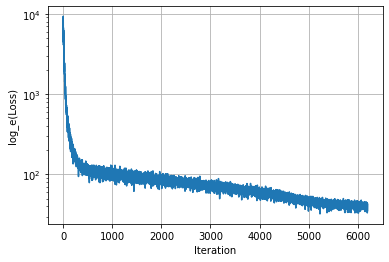

In [ ]:
def shuffle(X, Y):
    train_indices = np.arange(X.shape[0])
    np.random.shuffle(train_indices)
    X_result = X[train_indices,:, :]
    Y_result = Y[train_indices]
    return X_result, Y_result

def load_mnist_data():
    with open('mnist.pickle', 'rb') as f:
        print('Loading Pickled Data...')
        return pickle.load(f)

if __name__ == '__main__':
    # Clear old computational graphs
    tf.compat.v1.reset_default_graph()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    with tf.compat.v1.Session(config=config) as sess:

        (x_train, _) , (x_test, _) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
        # fashion_mnist = keras.datasets.fashion_mnist
        # (x_train, _), (x_test, _) = fashion_mnist.load_data()

        # x_train = x_train[:, :, :, 0]
        # x_train = x_train/np.max(x_train)
        # y_train = np.gradient(x_train, axis = (1,2))[0]
        # for i in range(y_train.shape[0]):
        #     y_train[i, :, :] = y_train[i, :, :] + np.abs(np.min(y_train[i, :, :]))
        #     y_train[i, :, :] = y_train[i, :, :]/np.max(y_train[i, :, :])

        # x_test = x_test[:, :, :, 0]
        # x_test = x_train/np.max(x_test)
        # y_test = np.gradient(x_test, axis = (1,2))[0]
        # for i in range(y_test.shape[0]):
        #     y_test[i, :, :] = y_test[i, :, :] + np.abs(np.min(y_test[i, :, :]))
        #     y_test[i, :, :] = y_test[i, :, :]/np.max(y_test[i, :, :])

        downsample_factor = 2
        y_train = x_train[:, :, :, 0]
        x_train = np.zeros((y_train.shape[0], int(y_train.shape[1]/downsample_factor), int(y_train.shape[1]/downsample_factor)))
        for i in range(y_train.shape[0]):
            x_train[i, :, :] = downscale_local_mean(y_train[i, :, :], (downsample_factor,downsample_factor))
            x_train[i, :, :] = x_train[i, :, :]/np.max(x_train[i, :, :])
        y_test = x_test[:, :, :, 0]
        x_test = np.zeros(((y_test.shape[0], int(y_test.shape[1]/downsample_factor), int(y_test.shape[1]/downsample_factor))))
        for i in range(y_test.shape[0]):
            x_test[i, :, :] = downscale_local_mean(y_test[i, :, :], (downsample_factor,downsample_factor))
            x_test[i, :, :] = x_test[i, :, :]/np.max(x_test[i, :, :])  
        
        num_train = 500
        num_val = 100
        num_test = 100
        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)
        x_val = x_train[-num_val::, :, :]
        y_val = y_train[-num_val::]
        x_train = x_train[0:num_train, :, :]
        y_train = y_train[0:num_train]
        x_test = x_test[0:num_test, :, :]
        y_test = y_test[0:num_test]   

        model = d2nn_model()

        sess.run(tf.compat.v1.global_variables_initializer())
        model.train(sess, x_train, y_train, x_val, y_val)
        loss, results = model.evaluate(sess, x_test, y_test)
        print('***** test loss: %.3f' % loss)
        saver = tf.compat.v1.train.Saver()
        model_path = saver.save(sess, "d2nn_diff.ckpt")
        print("Model saved in %s" % model_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


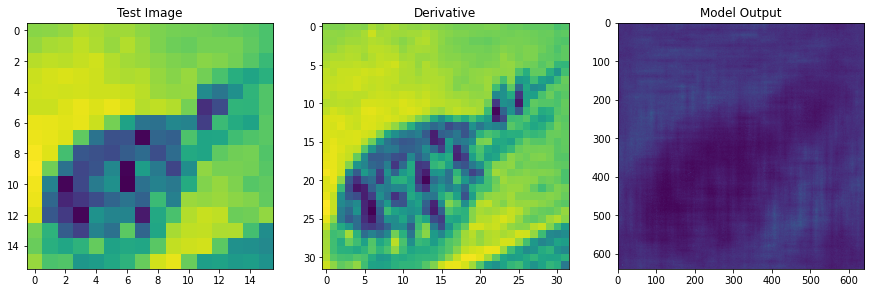

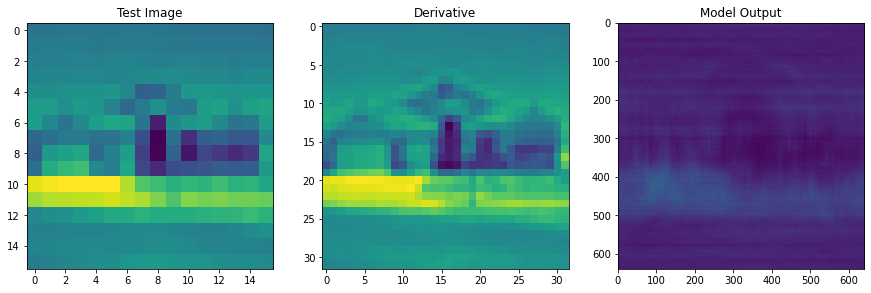

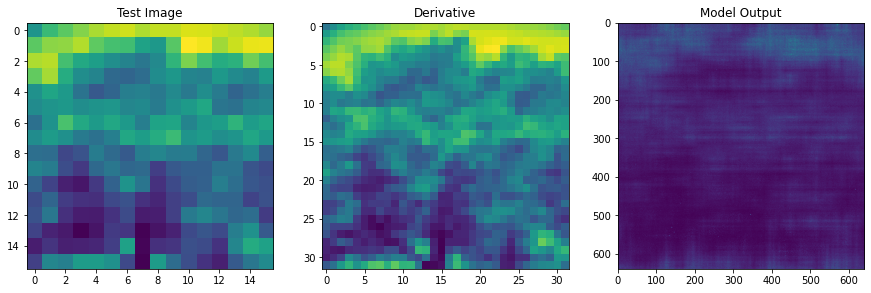

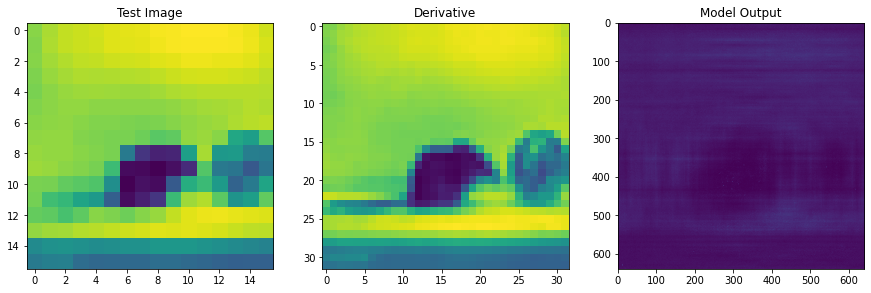

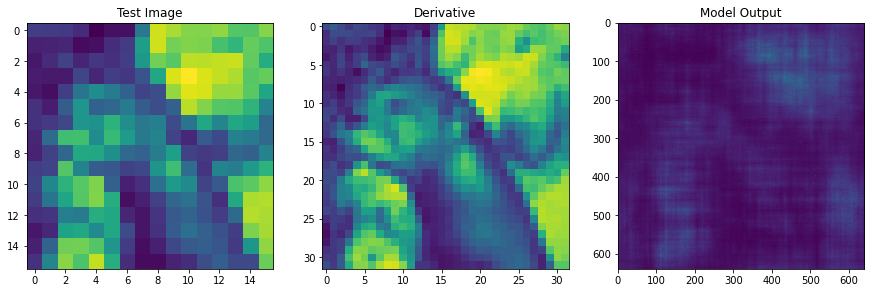

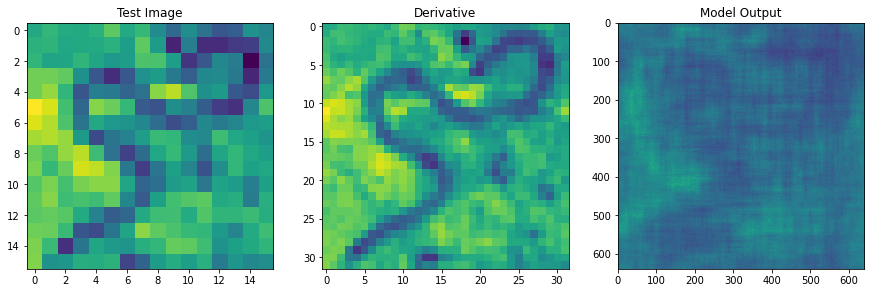

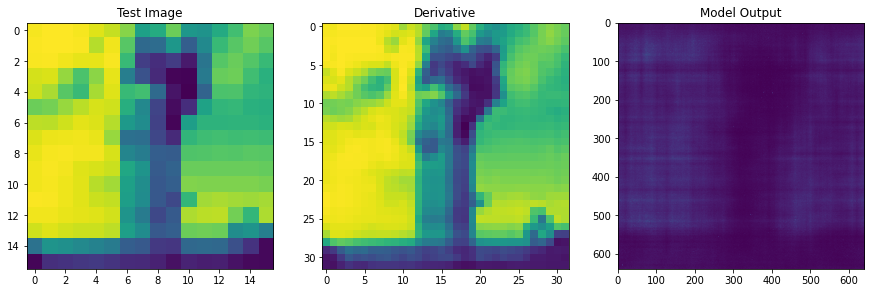

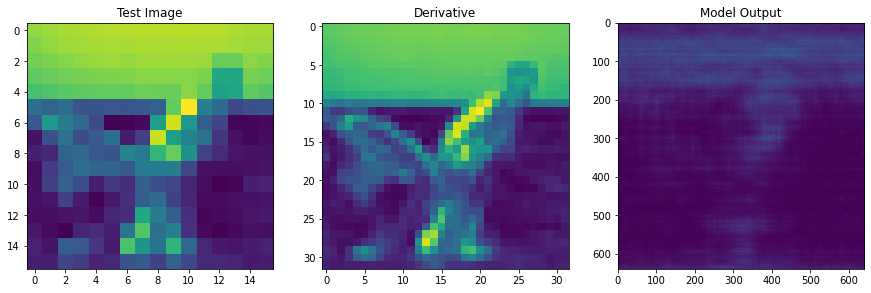

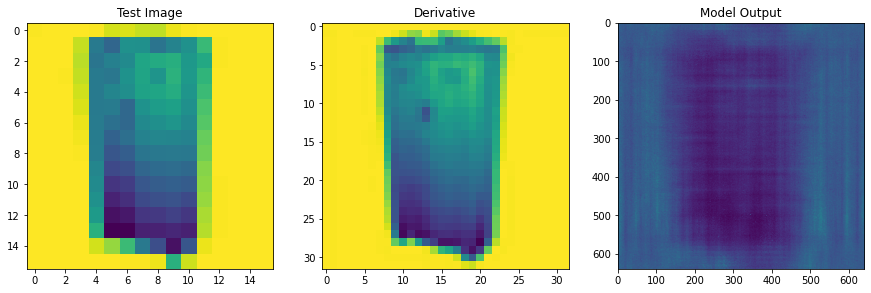

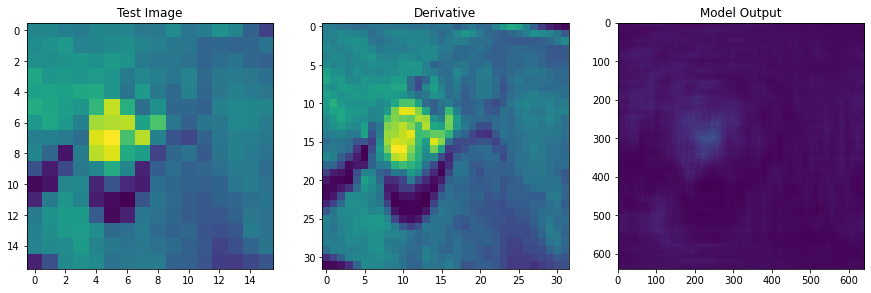

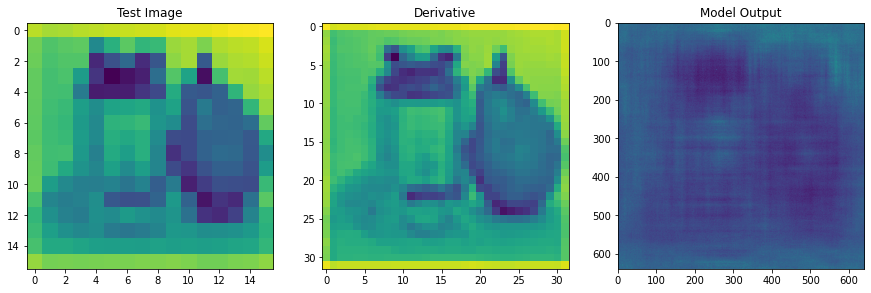

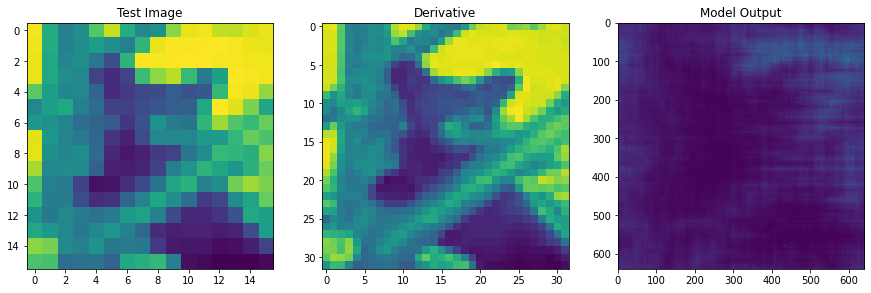

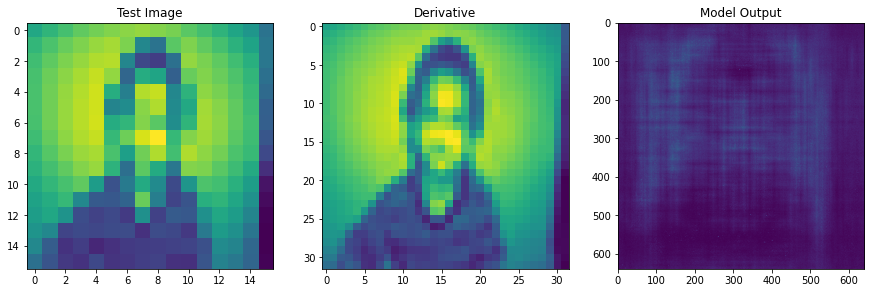

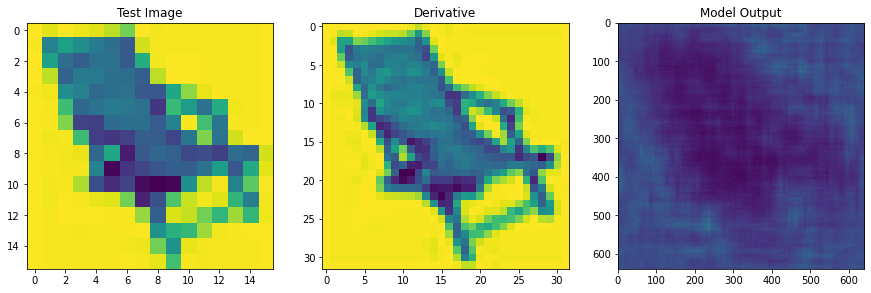

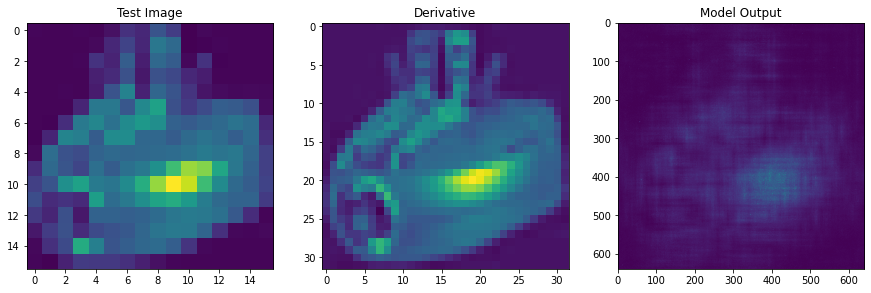

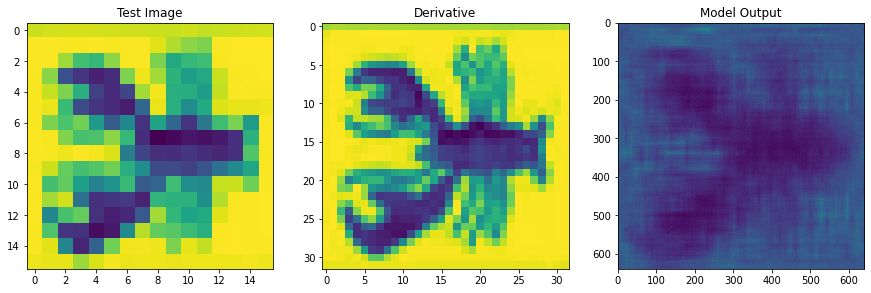

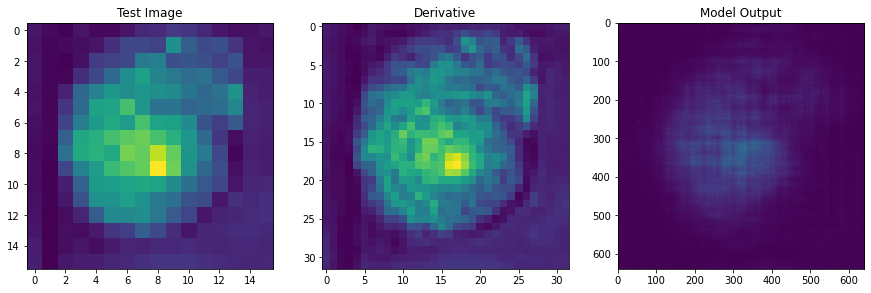

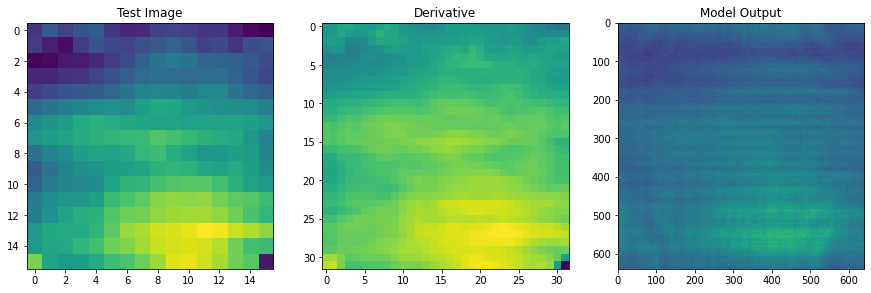

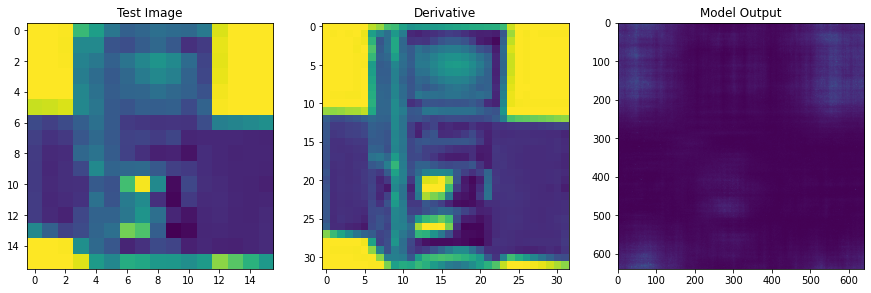

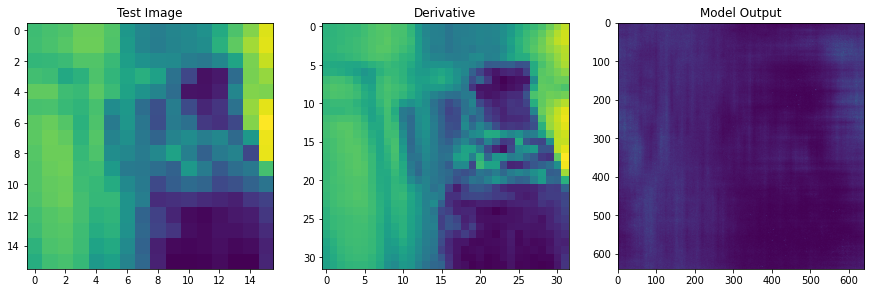

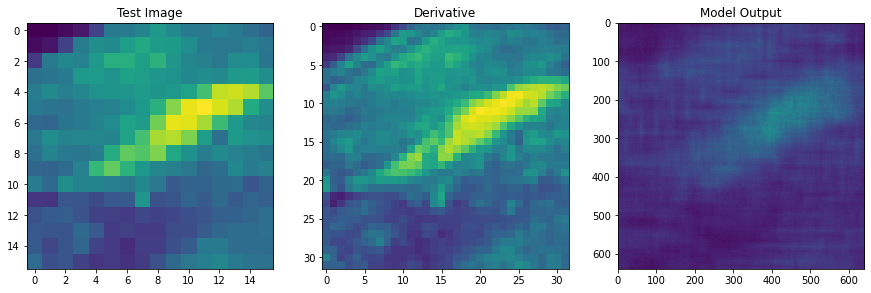

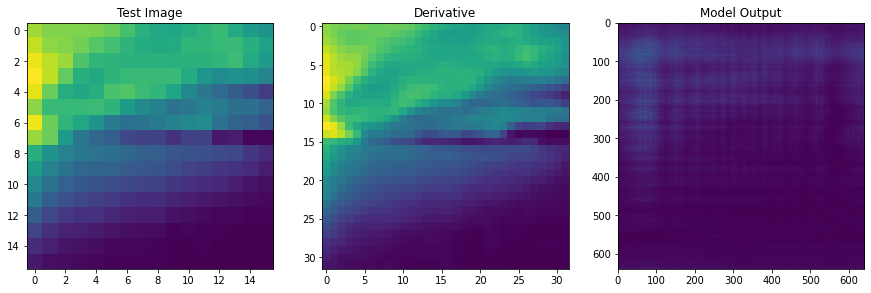

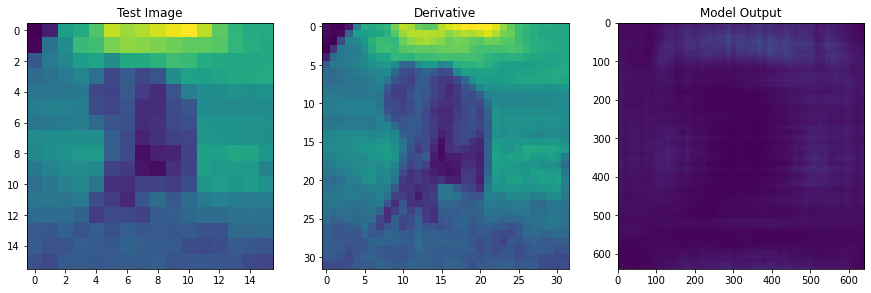

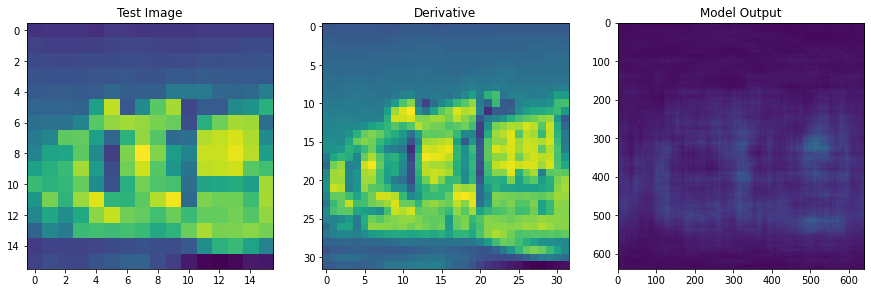

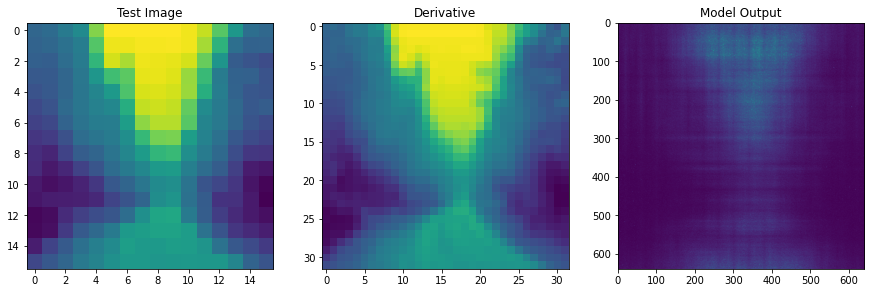

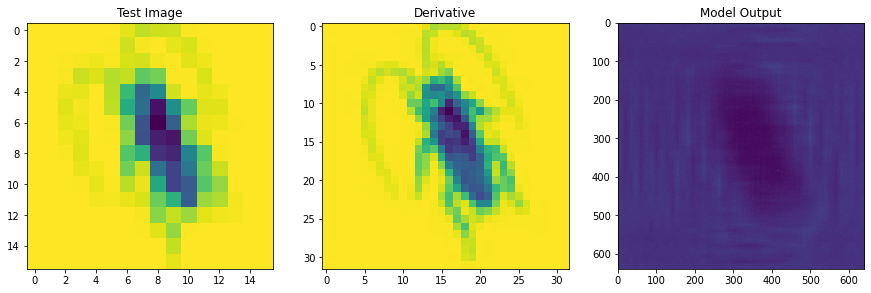

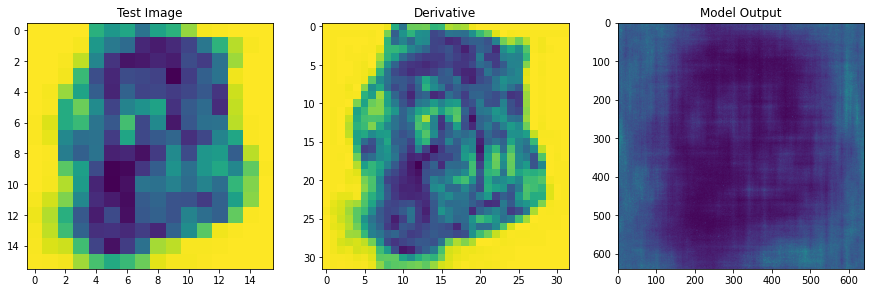

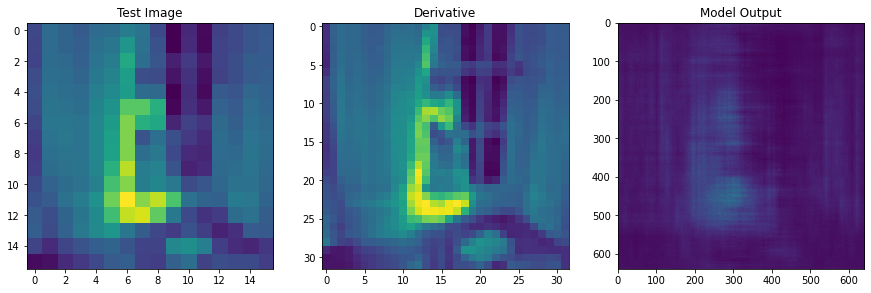

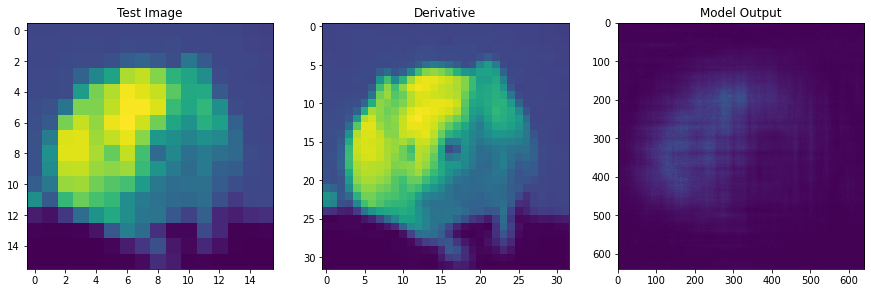

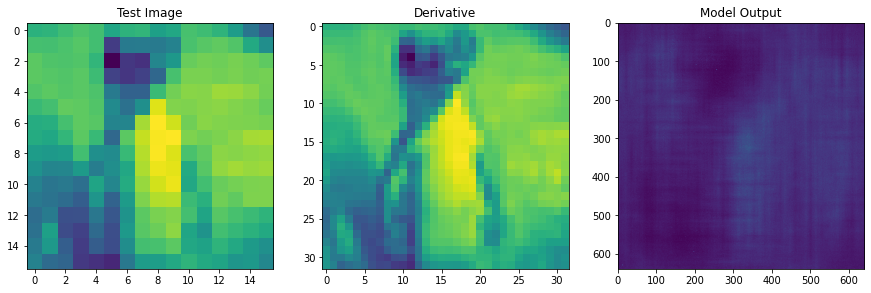

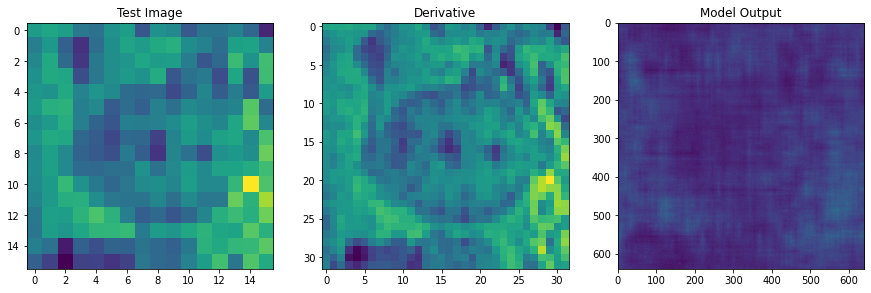

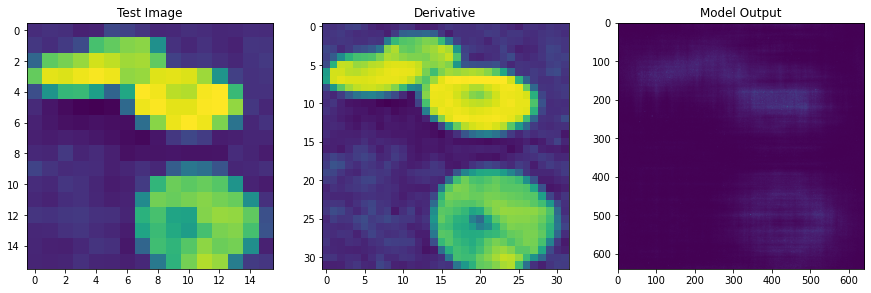

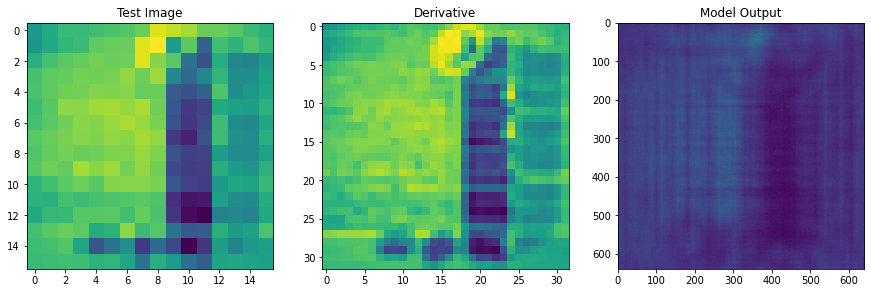

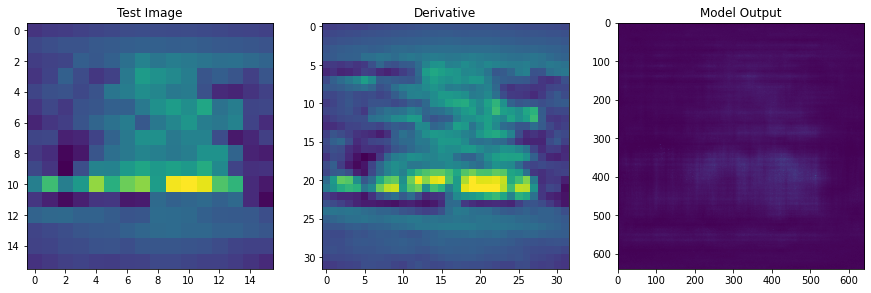

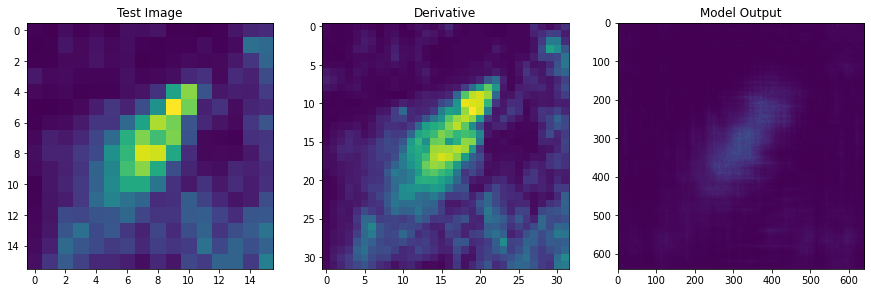

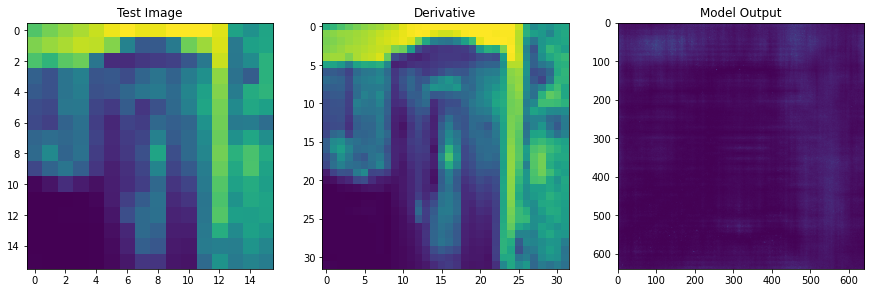

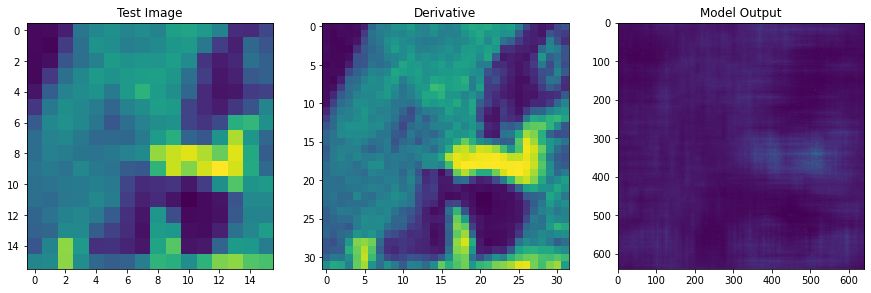

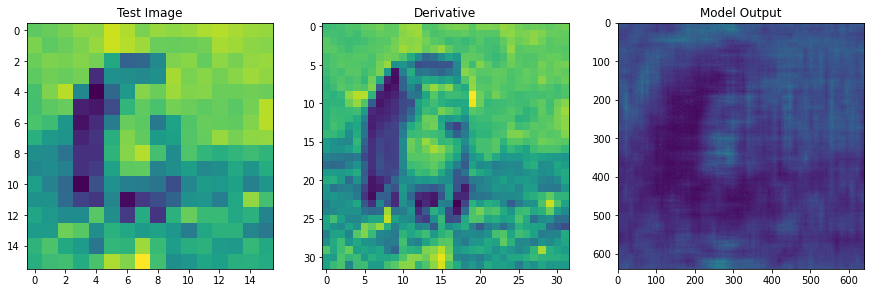

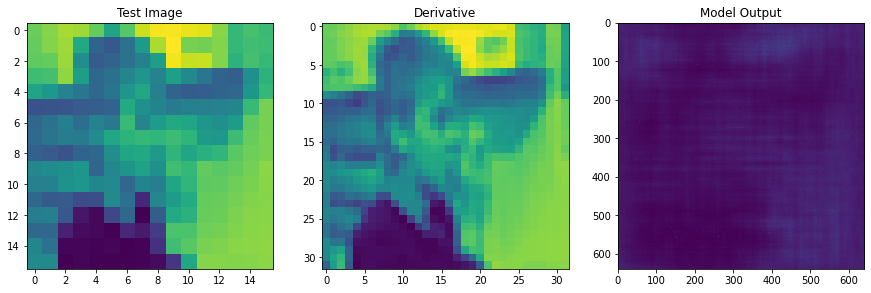

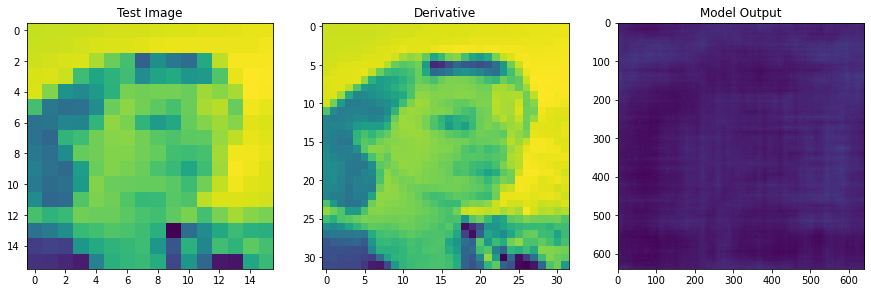

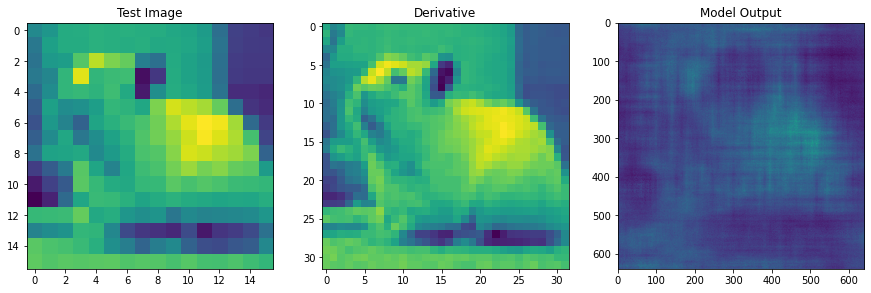

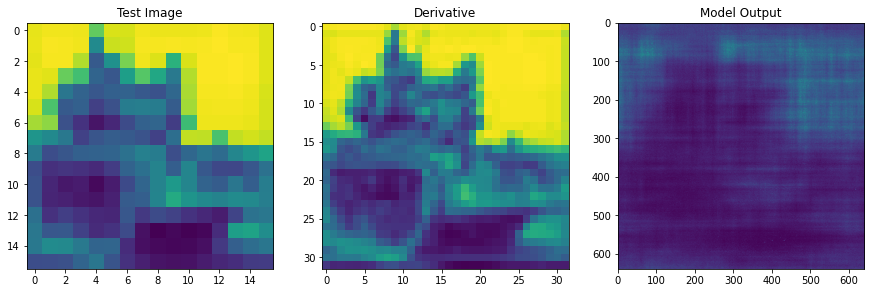

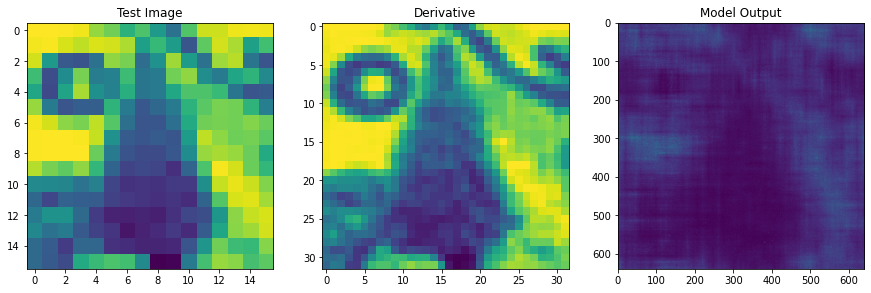

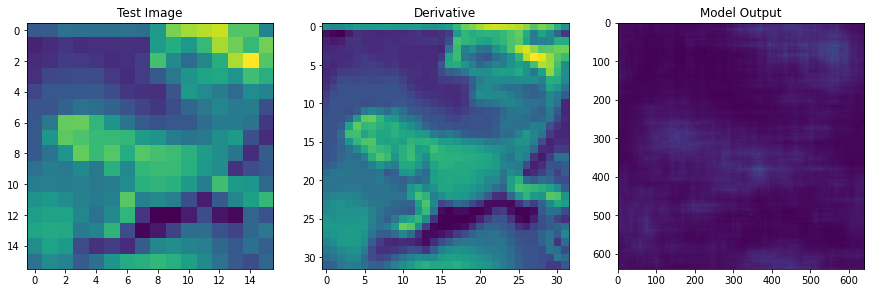

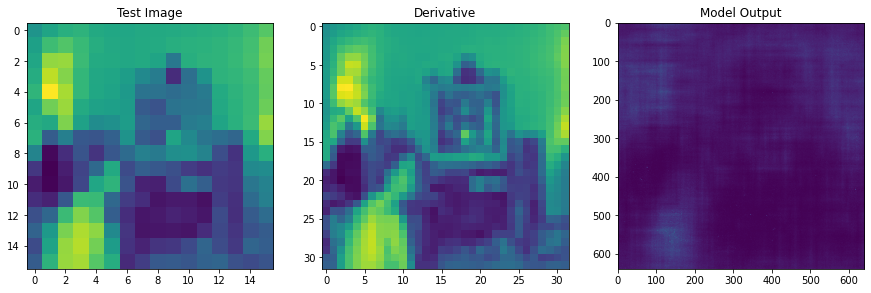

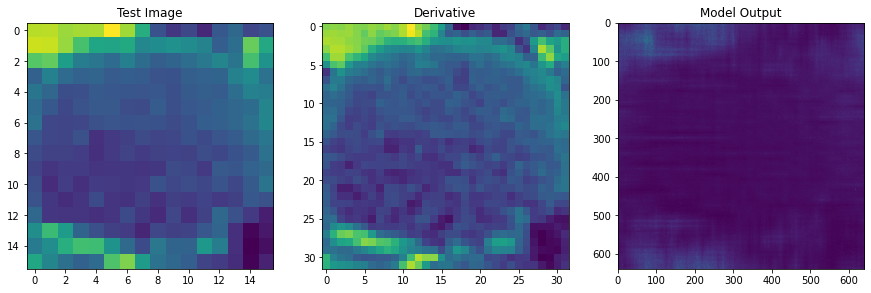

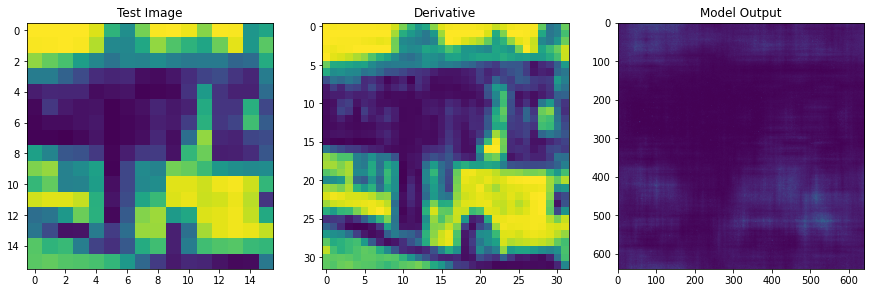

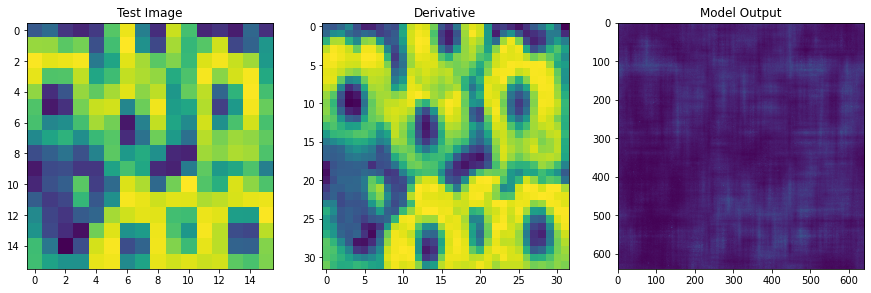

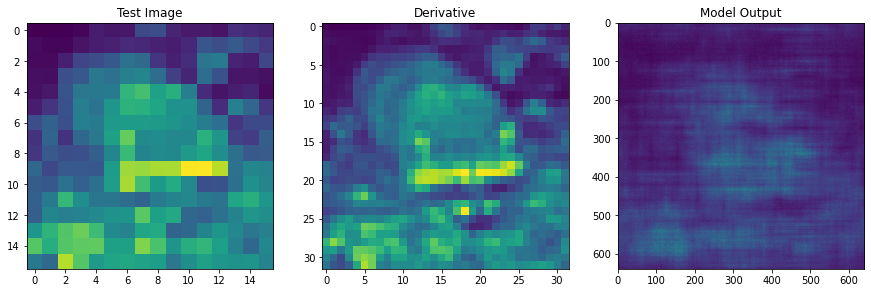

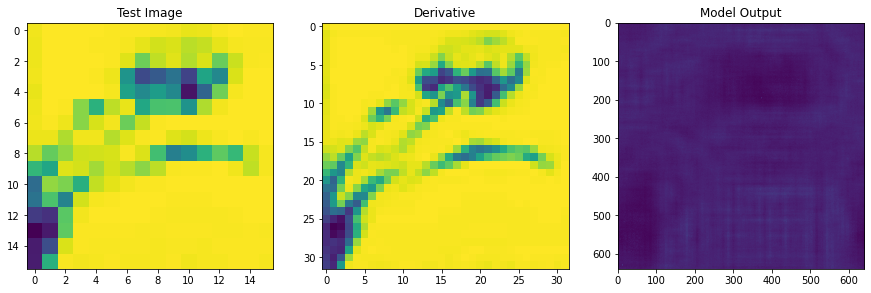

In [ ]:
idxs = np.arange(0, 50)

for idx in idxs:
    max_val1 = np.max(x_test[idx, :, :])
    max_val2 = np.max(y_test[idx, :, :])
    max_val3 = np.max(results[idx, :, :])
    max_val = np.max([max_val1, max_val2, max_val3])
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[idx, :, :])
    plt.title('Test Image')
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[idx, :, :])
    plt.title('Derivative')
    plt.subplot(1, 3, 3)
    plt.imshow(results[idx, :, :])
    plt.title('Model Output')
    plt.savefig('idx' + str(idx) + '.png')

In [ ]:
y_test.shape

(100, 32, 32)